<a href="https://colab.research.google.com/github/yeon524/IDS/blob/main/IDS_action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Raw dataframe shape: (104, 7)


,Subject,Session,Scenario,Duration,Periods,Start,End
0,U0101,S0100,S1,35m36s,20,2021-10-14 11:25:34+09:00,2021-10-14 12:01:10+09:00
1,U0101,S0200,S1,28m54s,20,2021-10-14 13:17:42+09:00,2021-10-14 13:46:36+09:00
2,U0101,S0300,S1,28m58s,20,2021-10-14 14:09:10+09:00,2021-10-14 14:38:08+09:00
3,U0101,S0400,S1,30m55s,20,2021-10-14 14:59:48+09:00,2021-10-14 15:30:43+09:00
4,U0101,S0500,S1,27m35s,20,2021-10-14 15:54:05+09:00,2021-10-14 16:21:40+09:00


Cleaned dataframe shape: (104, 8)
Scenarios: ['S1' 'S2' 'S3' 'S4']

Average duration (sec) by scenario


,Scenario,duration_sec
0,S1,2019.666667
1,S2,1846.350000
2,S3,1698.050000
3,S4,1388.600000



Average periods by scenario


,Scenario,Periods
0,S1,19.037037
1,S2,20.000000
2,S3,19.600000
3,S4,19.500000



Efficiency (sec per period) by scenario


,Scenario,sec_per_period
0,S1,106.336633
1,S2,92.317500
2,S3,87.145833
3,S4,71.220000


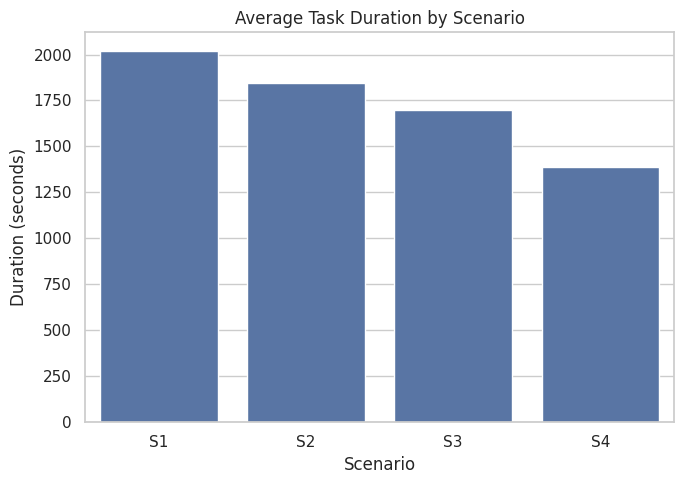

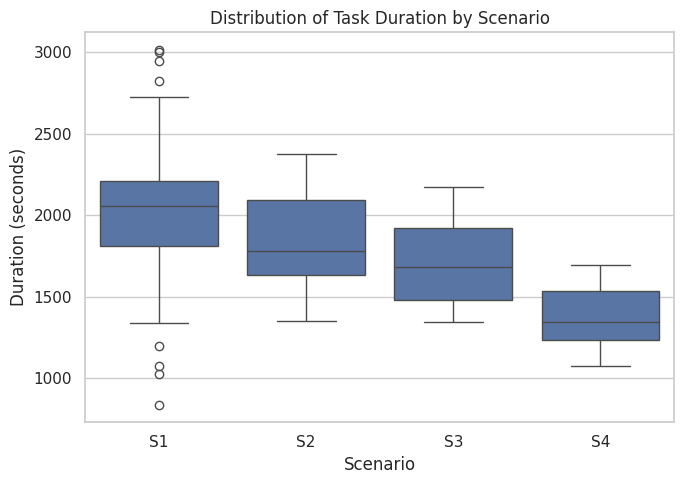

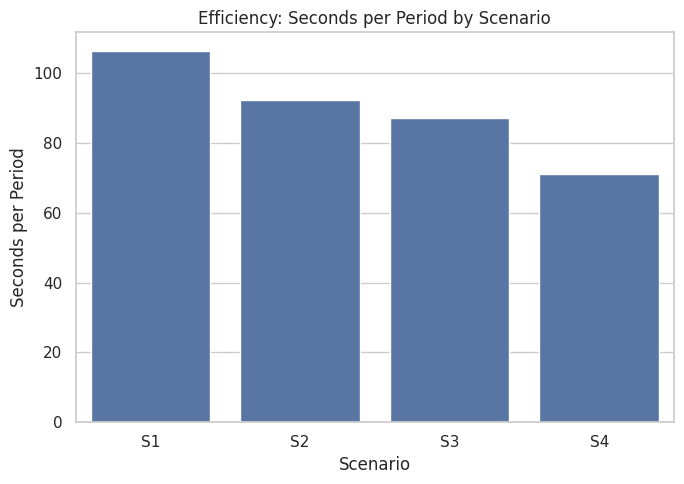

In [1]:

!rm -rf openpack-dataset
!git clone https://github.com/yeon524/openpack-dataset.git -q

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir("/content/openpack-dataset/docs/data-collection")



rows = []
with open("sessions.md", "r", encoding="utf-8") as f:
    for line in f:

        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        parts = [c.strip() for c in line.split("|") if c.strip()]
        if not parts:
            continue


        if not parts[0].startswith("U0"):
            continue


        if len(parts) >= 7:
            rows.append(parts[:7])

df = pd.DataFrame(rows, columns=["Subject","Session","Scenario",
                                 "Duration","Periods","Start","End"])

print("Raw dataframe shape:", df.shape)
display(df.head())



def duration_to_sec(x):
    if pd.isna(x):
        return np.nan
    x = x.strip()
    m = re.match(r"(\d+)m(\d+)s", x)
    if m:
        minutes = int(m.group(1))
        seconds = int(m.group(2))
        return minutes * 60 + seconds
    return np.nan  # 예상 패턴 아니면 NaN

df["duration_sec"] = df["Duration"].apply(duration_to_sec)



df["Scenario"] = df["Scenario"].str.strip()
valid_scenarios = ["S1","S2","S3","S4"]
df_clean = df[df["Scenario"].isin(valid_scenarios)].copy()

print("Cleaned dataframe shape:", df_clean.shape)
print("Scenarios:", df_clean["Scenario"].unique())



df_clean["Periods"] = pd.to_numeric(df_clean["Periods"], errors="coerce")
df_clean = df_clean.dropna(subset=["Periods"])



# (1) 평균 작업 시간
scenario_stats = (
    df_clean.groupby("Scenario")["duration_sec"]
            .mean()
            .reset_index()
)

# S1~S4 순서 정렬
order = ["S1","S2","S3","S4"]
scenario_stats["Scenario"] = pd.Categorical(scenario_stats["Scenario"],
                                            categories=order,
                                            ordered=True)
scenario_stats = scenario_stats.sort_values("Scenario")

print("\nAverage duration (sec) by scenario")
display(scenario_stats)

# (2) 시나리오별 평균 Periods
period_stats = (
    df_clean.groupby("Scenario")["Periods"]
            .mean()
            .reset_index()
)

period_stats["Scenario"] = pd.Categorical(period_stats["Scenario"],
                                          categories=order,
                                          ordered=True)
period_stats = period_stats.sort_values("Scenario")

print("\nAverage periods by scenario")
display(period_stats)

# (3) 효율: Seconds per Period
df_clean["sec_per_period"] = df_clean["duration_sec"] / df_clean["Periods"]

eff_stats = (
    df_clean.groupby("Scenario")["sec_per_period"]
            .mean()
            .reset_index()
)

eff_stats["Scenario"] = pd.Categorical(eff_stats["Scenario"],
                                       categories=order,
                                       ordered=True)
eff_stats = eff_stats.sort_values("Scenario")

print("\nEfficiency (sec per period) by scenario")
display(eff_stats)



sns.set(style="whitegrid")

# (A) Scenario별 평균 작업 시간
plt.figure(figsize=(7,5))
sns.barplot(data=scenario_stats, x="Scenario", y="duration_sec")
plt.title("Average Task Duration by Scenario")
plt.xlabel("Scenario")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()

# (B) Scenario별 작업 시간 분포 (Boxplot)
plt.figure(figsize=(7,5))
sns.boxplot(data=df_clean, x="Scenario", y="duration_sec",
            order=order)
plt.title("Distribution of Task Duration by Scenario")
plt.xlabel("Scenario")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()


# (C) Scenario별 효율 (Seconds per Period)
plt.figure(figsize=(7,5))
sns.barplot(data=eff_stats, x="Scenario", y="sec_per_period")
plt.title("Efficiency: Seconds per Period by Scenario")
plt.xlabel("Scenario")
plt.ylabel("Seconds per Period")
plt.tight_layout()
plt.show()


=== Worker-level speed & consistency (전체 세션 기준) ===


,Subject,mean,std,count,cv
3,U0104,2294.25,870.376308,4,0.379373
1,U0102,2277.00,457.419938,5,0.200887
8,U0109,2216.60,298.738682,5,0.134773
7,U0108,2191.80,131.968557,5,0.060210
10,U0111,2180.60,286.267882,5,0.131279
4,U0105,2140.60,192.986528,5,0.090155
5,U0106,2063.40,682.802900,5,0.330912
13,U0203,1940.60,232.493656,5,0.119805
15,U0205,1865.40,258.640291,5,0.138651
11,U0201,1823.60,434.876189,5,0.238471


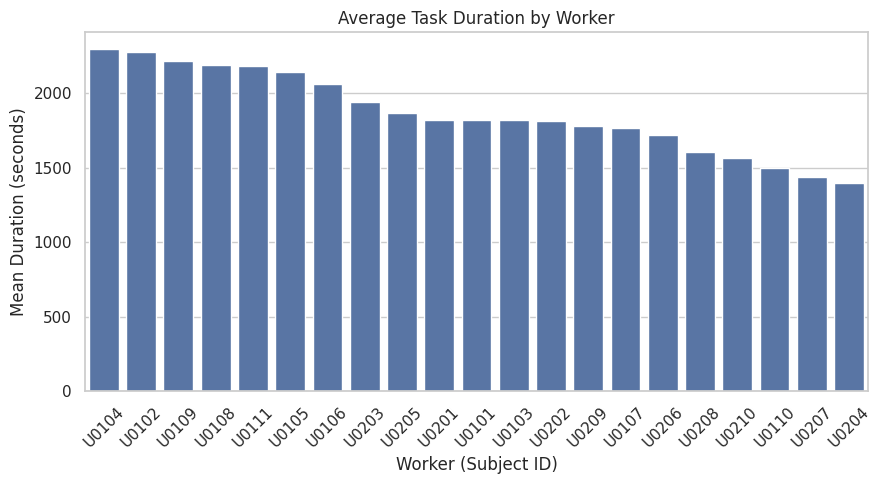

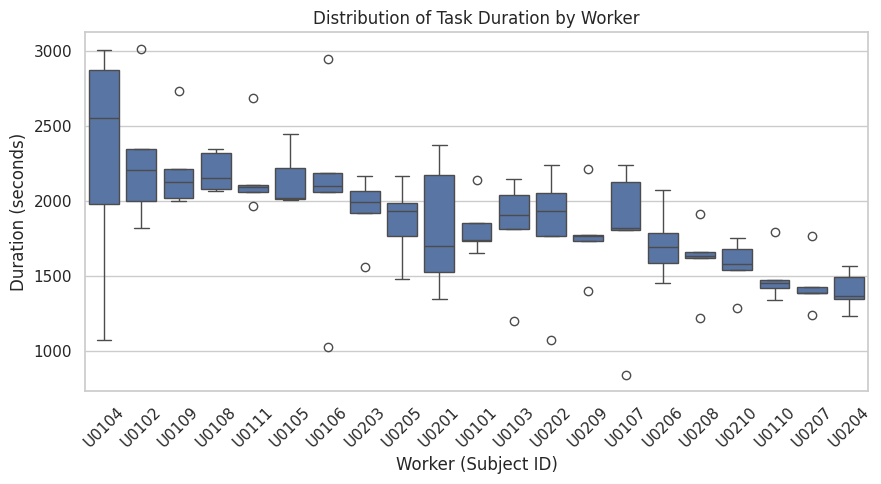

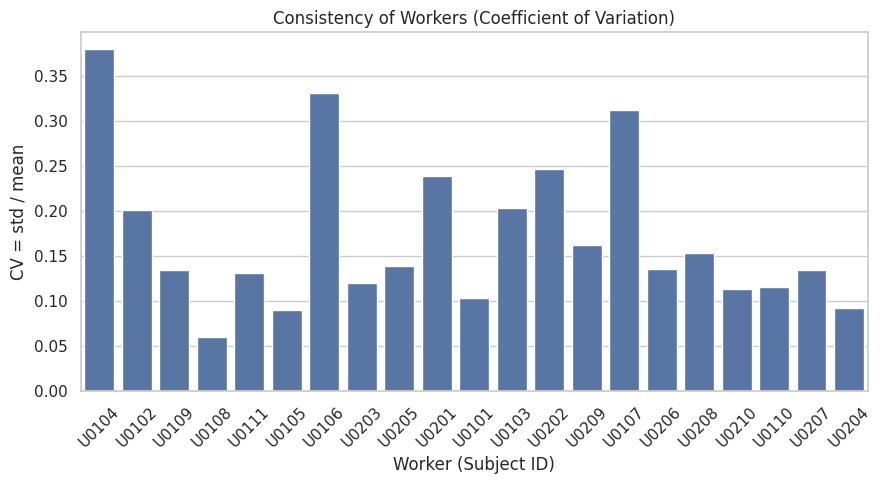

=== Average duration by Worker x Scenario ===


Scenario,S1,S2,S3,S4
Subject,,,,
U0101,1823.60,NaN,NaN,NaN
U0102,2277.00,NaN,NaN,NaN
U0103,1820.20,NaN,NaN,NaN
U0104,2294.25,NaN,NaN,NaN
U0105,2140.60,NaN,NaN,NaN
U0106,2063.40,NaN,NaN,NaN
U0107,1765.40,NaN,NaN,NaN
U0108,2191.80,NaN,NaN,NaN
U0109,2216.60,NaN,NaN,NaN


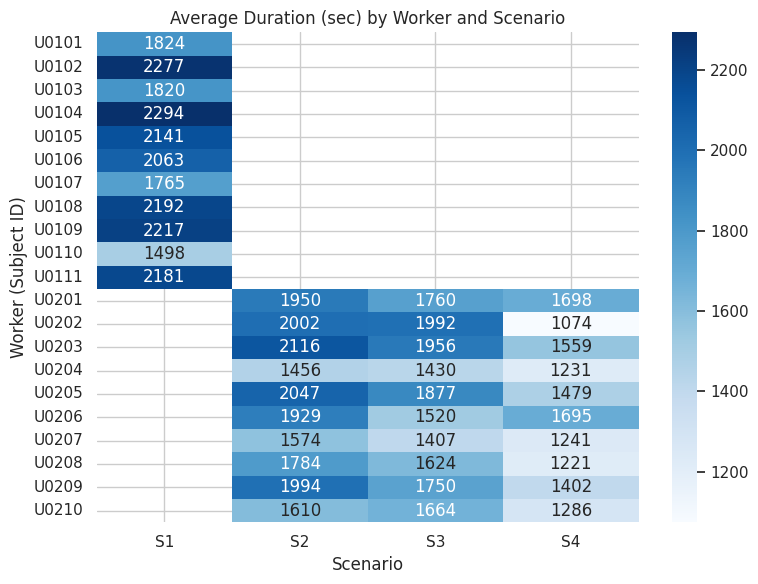

In [2]:
# ============================================
#  Worker(Subject)별 속도 & 일관성 분석
#  (df_clean 이 이미 존재한다고 가정)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1) Worker(Subject)별 기본 통계 ==============================
worker_stats = (
    df_clean.groupby("Subject")["duration_sec"]
            .agg(["mean", "std", "count"])
            .reset_index()
)

# 일관성 지표: 표준편차 / 평균  (Coefficient of Variation)
worker_stats["cv"] = worker_stats["std"] / worker_stats["mean"]

# 평균 시간 기준으로 정렬 (느린 사람 순)
worker_stats = worker_stats.sort_values("mean", ascending=False)

print("=== Worker-level speed & consistency (전체 세션 기준) ===")
display(worker_stats)

# 2) 시각화 1: Worker별 평균 작업 시간 =========================
plt.figure(figsize=(9,5))
sns.barplot(data=worker_stats, x="Subject", y="mean")
plt.title("Average Task Duration by Worker")
plt.xlabel("Worker (Subject ID)")
plt.ylabel("Mean Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) 시각화 2: Worker별 작업 시간 분포(Boxplot) =================
plt.figure(figsize=(9,5))
sns.boxplot(data=df_clean, x="Subject", y="duration_sec",
            order=worker_stats["Subject"])  # 위에서 정렬한 순서대로
plt.title("Distribution of Task Duration by Worker")
plt.xlabel("Worker (Subject ID)")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4) 시각화 3: Worker별 일관성(CV) ============================
plt.figure(figsize=(9,5))
sns.barplot(data=worker_stats, x="Subject", y="cv")
plt.title("Consistency of Workers (Coefficient of Variation)")
plt.xlabel("Worker (Subject ID)")
plt.ylabel("CV = std / mean")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5) 추가: Scenario x Worker 교차 테이블 (평균 시간) ==============
scenario_worker_stats = (
    df_clean.groupby(["Subject", "Scenario"])["duration_sec"]
            .mean()
            .reset_index()
            .pivot(index="Subject", columns="Scenario", values="duration_sec")
)

print("=== Average duration by Worker x Scenario ===")
display(scenario_worker_stats)

plt.figure(figsize=(8,6))
sns.heatmap(scenario_worker_stats, annot=True, fmt=".0f",
            cmap="Blues")
plt.title("Average Duration (sec) by Worker and Scenario")
plt.xlabel("Scenario")
plt.ylabel("Worker (Subject ID)")
plt.tight_layout()
plt.show()


In [33]:
# ============================================
# Objective 2: Task Complexity & Item Characteristics
#  - 상품 크기/수량/부피  ↔  작업 시간 관계 분석
# ============================================

import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --------------------------------------------
# 0. OpenPack 저장소 준비 (이미 clone 했으면 건너뜀)
# --------------------------------------------
if not os.path.exists("openpack-dataset"):
    !git clone https://github.com/yeon524/openpack-dataset.git

BASE_DIR = "openpack-dataset"

# --------------------------------------------
# 1. items.csv : 상품 물리적 특성 (크기, 부피)
# --------------------------------------------
items_path = os.path.join(BASE_DIR, "data", "items.csv")
items = pd.read_csv(items_path)

# 숫자형으로 변환 (혹시 문자열이면)
for col in ["height_cm", "width_cm", "depth_cm"]:
    items[col] = pd.to_numeric(items[col], errors="coerce")

# 상품 1개당 부피(cm^3)
items["volume_cm3"] = items["height_cm"] * items["width_cm"] * items["depth_cm"]

items_small = items[["item_id", "size_category", "volume_cm3"]]
print("items 샘플")
print(items_small.head())

# --------------------------------------------
# 2. order-list : 주문별 item 정보 + 수량
#    (U0101.csv ~ U0210.csv 전부 로드)
# --------------------------------------------
order_dir = os.path.join(BASE_DIR, "data", "openpack", "order-list")
order_files = sorted(glob.glob(os.path.join(order_dir, "U*.csv")))

order_list = []
for f in order_files:
    user_id = os.path.basename(f).split(".")[0]  # U0101 같은 ID
    df = pd.read_csv(f)
    df["user"] = user_id
    order_list.append(df)

orders_raw = pd.concat(order_list, ignore_index=True)

print("\norder-list 샘플")
print(orders_raw.head())

# --------------------------------------------
# 3. order-list wide → long 변환
#    (item1~item5, amount1~amount5 펼치기)
# --------------------------------------------
item_cols = [f"item{i}" for i in range(1, 6)]
amt_cols  = [f"amount{i}" for i in range(1, 6)]

# wide → long
long_rows = []
for i in range(1, 6):
    tmp = orders_raw[["user", "session", "box", "sheet_no", "total_amount"]].copy()
    tmp["item_id"] = orders_raw[f"item{i}"]
    tmp["amount"]  = orders_raw[f"amount{i}"]
    long_rows.append(tmp)

orders_long = pd.concat(long_rows, ignore_index=True)

# item_id가 NaN 이거나 amount 0/NaN 인 행은 제거
orders_long = orders_long.dropna(subset=["item_id"])
orders_long = orders_long[orders_long["amount"].fillna(0) > 0]

# item_id 정수형으로 통일
orders_long["item_id"] = orders_long["item_id"].astype(int)

print("\nlong format 샘플")
print(orders_long.head())

# --------------------------------------------
# 4. items와 join → 주문별 총 부피/평균 부피 계산
# --------------------------------------------
orders_long = orders_long.merge(items_small, on="item_id", how="left")

# 각 행: 특정 주문 내 특정 item의 "총 부피"
orders_long["item_total_volume"] = orders_long["volume_cm3"] * orders_long["amount"]

# 주문 단위 집계 (user, session, box, sheet_no 기준)
order_complexity = (
    orders_long
    .groupby(["user", "session", "box", "sheet_no"], as_index=False)
    .agg(
        total_items=("amount", "sum"),              # 전체 수량
        n_unique_items=("item_id", "nunique"),      # 서로 다른 상품 종류 수
        total_volume=("item_total_volume", "sum"),  # 주문 전체 부피
        mean_item_volume=("volume_cm3", "mean"),    # 상품 1개 평균 부피
    )
)

# total_amount(원래 order-list에 있던 값)도 가져와 비교용
order_complexity = order_complexity.merge(
    orders_raw[["user", "session", "box", "sheet_no", "total_amount"]],
    on=["user", "session", "box", "sheet_no"],
    how="left"
)

print("\n주문 복잡도(order_complexity) 샘플")
print(order_complexity.head())

# --------------------------------------------
# 5. openpack-operations-1hz 로부터 작업 시간(duration) 계산
#    - 1Hz → 행 개수 = 초 단위 작업 시간
# --------------------------------------------
ops_files = sorted(
    glob.glob(
        os.path.join(BASE_DIR, "data", "openpack", "v1.0.0", "U*", "annotation",
                     "openpack-operations-1hz", "S0500.csv")
    )
)

ops_list = []
for f in ops_files:
    # .../U0209/annotation/.../S0500.csv → U0209 추출
    user_id = f.split(os.sep)[-4]
    df = pd.read_csv(f)
    df["user"] = user_id
    ops_list.append(df)

ops = pd.concat(ops_list, ignore_index=True)

print("\noperations-1hz 샘플")
print(ops.head())

# duration_sec = 해당 (user, session, box)의 1Hz row 개수
duration = (
    ops.groupby(["user", "session", "box"], as_index=False)
       .size()
       .rename(columns={"size": "duration_sec"})
)

print("\n작업 시간(duration_sec) 샘플")
print(duration.head())

# --------------------------------------------
# 6. 주문 복잡도 + 작업 시간 병합
# --------------------------------------------
data = order_complexity.merge(
    duration,
    on=["user", "session", "box"],
    how="inner"
)

print("\n최종 분석 데이터 샘플")
print(data.head())

# --------------------------------------------
# 7. 간단한 상관계수 확인
# --------------------------------------------
corr_cols = ["duration_sec", "total_items", "n_unique_items",
             "total_volume", "mean_item_volume", "total_amount"]

print("\n상관계수 (duration_sec 과의 관계)")
print(data[corr_cols].corr()["duration_sec"].sort_values(ascending=False))

# --------------------------------------------
# 8. 시각화 1: total_items ↔ duration_sec
# --------------------------------------------
plt.figure(figsize=(6,4))
sns.regplot(data=data, x="total_items", y="duration_sec", scatter_kws={"alpha":0.3})
plt.title("Total Items vs Task Duration")
plt.xlabel("Total Items in Order")
plt.ylabel("Task Duration (sec)")
plt.show()

# --------------------------------------------
# 9. 시각화 2: total_volume ↔ duration_sec
# --------------------------------------------
plt.figure(figsize=(6,4))
sns.regplot(data=data, x="total_volume", y="duration_sec", scatter_kws={"alpha":0.3})
plt.title("Total Volume vs Task Duration")
plt.xlabel("Total Volume of Order (cm^3)")
plt.ylabel("Task Duration (sec)")
plt.show()

# --------------------------------------------
# 10. 시각화 3: 주문 크기(부피)에 따른 작업시간 Boxplot
#     - total_volume 를 3~4구간으로 쪼개서 보기
# --------------------------------------------
# 분위수 기반 구간 나누기
data["volume_bin"] = pd.qcut(data["total_volume"], q=4, labels=["Q1 (small)", "Q2", "Q3", "Q4 (large)"])

plt.figure(figsize=(6,4))
sns.boxplot(data=data, x="volume_bin", y="duration_sec")
plt.title("Task Duration by Order Volume Quartile")
plt.xlabel("Order Volume Quartile")
plt.ylabel("Task Duration (sec)")
plt.show()

# --------------------------------------------
# 11. 시각화 4: item 개수에 따른 작업시간 Boxplot
# --------------------------------------------
data["item_bin"] = pd.qcut(data["total_items"], q=4, labels=["Q1 (few)", "Q2", "Q3", "Q4 (many)"])

plt.figure(figsize=(6,4))
sns.boxplot(data=data, x="item_bin", y="duration_sec")
plt.title("Task Duration by Total Items Quartile")
plt.xlabel("Total Items Quartile")
plt.ylabel("Task Duration (sec)")
plt.show()


KeyError: 'height_cm'

In [32]:
import pandas as pd

items = pd.read_csv("/content/openpack-dataset/data/items.csv")

items.head()

,item_id,name,JAN_code,height__cm,width__cm,depth__cm,size_category,amount,url
0,101,Panasonic 5 AA battery pack 1,4902704218810,9.0,7.0,3.0,0-10cm,1,NaN
1,102,Panasonic 5 AA battery pack 2,4902704218827,9.0,7.0,3.0,0-10cm,1,NaN
2,103,Panasonic 5 AA battery pack 3,4973934413047,9.0,7.0,3.0,0-10cm,1,NaN
3,104,Panasonic 5 AA battery pack 4,4902704218827,9.0,7.0,3.0,0-10cm,1,NaN
4,105,Panasonic 5 AA battery pack 5,4902704218827,9.0,7.0,3.0,0-10cm,1,NaN


In [31]:
import pandas as pd

# 1. items 데이터 다시 읽기 (이미 읽었으면 이 줄은 생략해도 됨)
items = pd.read_csv("/content/openpack-dataset/data/items.csv")

# 2. 컬럼 이름 정리: height__cm → height_cm 이런 식으로 통일
items = items.rename(columns={
    "height__cm": "height_cm",
    "width__cm": "width_cm",
    "depth__cm": "depth_cm"
})

print(items.columns)  # 이름 제대로 바뀌었는지 확인용

# 3. 물리적 크기 지표(볼륨) 만들기 예시
items["volume_cm3"] = items["height_cm"] * items["width_cm"] * items["depth_cm"]

items.head()


Index(['item_id', 'name', 'JAN_code', 'height_cm', 'width_cm', 'depth_cm',
       'size_category', 'amount', 'url'],
      dtype='object')


,item_id,name,JAN_code,height_cm,width_cm,depth_cm,size_category,amount,url,volume_cm3
0,101,Panasonic 5 AA battery pack 1,4902704218810,9.0,7.0,3.0,0-10cm,1,NaN,189.0
1,102,Panasonic 5 AA battery pack 2,4902704218827,9.0,7.0,3.0,0-10cm,1,NaN,189.0
2,103,Panasonic 5 AA battery pack 3,4973934413047,9.0,7.0,3.0,0-10cm,1,NaN,189.0
3,104,Panasonic 5 AA battery pack 4,4902704218827,9.0,7.0,3.0,0-10cm,1,NaN,189.0
4,105,Panasonic 5 AA battery pack 5,4902704218827,9.0,7.0,3.0,0-10cm,1,NaN,189.0


In [30]:
items = pd.read_csv("openpack-dataset/data/items.csv")
print(items.columns)
items.head()

Index(['item_id', 'name', 'JAN_code', 'height__cm', 'width__cm', 'depth__cm',
       'size_category', 'amount', 'url'],
      dtype='object')


,item_id,name,JAN_code,height__cm,width__cm,depth__cm,size_category,amount,url
0,101,Panasonic 5 AA battery pack 1,4902704218810,9.0,7.0,3.0,0-10cm,1,NaN
1,102,Panasonic 5 AA battery pack 2,4902704218827,9.0,7.0,3.0,0-10cm,1,NaN
2,103,Panasonic 5 AA battery pack 3,4973934413047,9.0,7.0,3.0,0-10cm,1,NaN
3,104,Panasonic 5 AA battery pack 4,4902704218827,9.0,7.0,3.0,0-10cm,1,NaN
4,105,Panasonic 5 AA battery pack 5,4902704218827,9.0,7.0,3.0,0-10cm,1,NaN


In [6]:
# =============================================================
# Objective 2: items.csv × order-list 병합 코드
# =============================================================

import pandas as pd
import numpy as np
import glob
import os

# --------------------------------------------
# 1) Load items.csv
# --------------------------------------------
items = pd.read_csv("/content/openpack-dataset/data/items.csv")

# 필요한 변수만 사용
items_use = items[["item_id", "size_category", "height__cm", "width__cm", "depth__cm"]]
items_use.head()


# --------------------------------------------
# 2) Load all order-list files (U0101 ~ U0210)
# --------------------------------------------
path = "/content/openpack-dataset/data/order-list/*.csv"
order_files = glob.glob(path)

all_orders = []

for file in order_files:
    df = pd.read_csv(file)

    # 파일명으로부터 session_id 생성
    session_id = os.path.basename(file).replace(".csv", "")
    df["Session"] = session_id   # U0101, U0102 ...

    all_orders.append(df)

order_raw = pd.concat(all_orders, ignore_index=True)


print("Order-list merged shape:", order_raw.shape)
display(order_raw.head())


# --------------------------------------------
# 3) item1~item5 + amount1~amount5 → long-format 변환
# --------------------------------------------

item_cols   = ["item1","item2","item3","item4","item5"]
amount_cols = ["amount1","amount2","amount3","amount4","amount5"]

long_rows = []

for idx, row in order_raw.iterrows():
    for i in range(5):
        item_id = row[item_cols[i]]
        amount  = row[amount_cols[i]]

        if pd.notna(item_id):
            long_rows.append({
                "Session": row["Session"],
                "sheet_no": row["sheet_no"],
                "item_id": int(item_id),
                "quantity": int(amount) if pd.notna(amount) else 1
            })

order_long = pd.DataFrame(long_rows)
print("Long-format order data:", order_long.shape)
display(order_long.head())


# --------------------------------------------
# 4) order-long × items.csv merge
# --------------------------------------------

order_merged = order_long.merge(items_use, on="item_id", how="left")
print("Merged with item info:", order_merged.shape)
display(order_merged.head())


# ---------------------------------------------------------
# 5) Create Session-level item summary (Objective 2 feature)
# ---------------------------------------------------------

session_item_summary = (
    order_merged.groupby("Session")
    .agg(
        total_items = ("item_id", "count"),
        total_quantity = ("quantity", "sum"),
        unique_item_types = ("item_id", "nunique"),

        # size_category 관련 ratio
        small_ratio  = ("size_category", lambda x: np.mean(x == "0-10cm")),
        medium_ratio = ("size_category", lambda x: np.mean(x == "10-20cm")),
        large_ratio  = ("size_category", lambda x: np.mean(x == "20-30cm")),

        # 평균 물리 크기
        mean_height = ("height__cm", "mean"),
        mean_width  = ("width__cm", "mean"),
        mean_depth  = ("depth__cm", "mean"),
    )
    .reset_index()
)

print(">> Session-level item summary")
display(session_item_summary.head())


# ---------------------------------------------------------
# 6) df_clean과 session-level item info merge
# ---------------------------------------------------------

df_final = df_clean.merge(session_item_summary, on="Session", how="left")

print(">> Final merged dataset (df_final):")
print(df_final.shape)
display(df_final.head())


Order-list merged shape: (2300, 16)


,sheet_no,session,box,pattern,total_amount,item1,item2,item3,item4,item5,amount1,amount2,amount3,amount4,amount5,Session
0,DEN010001,1,1,S2,3,113,201.0,NaN,NaN,NaN,2,1.0,NaN,NaN,NaN,U0207
1,DEN010002,1,2,M1,1,402,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,U0207
2,DEN010003,1,3,M1,1,314,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,U0207
3,DEN010004,1,4,L4,4,501,502.0,503.0,602.0,NaN,1,1.0,1.0,1.0,NaN,U0207
4,DEN010005,1,5,M3,3,308,404.0,406.0,NaN,NaN,1,1.0,1.0,NaN,NaN,U0207


Long-format order data: (4225, 4)


,Session,sheet_no,item_id,quantity
0,U0207,DEN010001,113,2
1,U0207,DEN010001,201,1
2,U0207,DEN010002,402,1
3,U0207,DEN010003,314,1
4,U0207,DEN010004,501,1


Merged with item info: (4225, 8)


,Session,sheet_no,item_id,quantity,size_category,height__cm,width__cm,depth__cm
0,U0207,DEN010001,113,2,0-10cm,4.0,7.0,2.0
1,U0207,DEN010001,201,1,10-20cm,17.0,8.0,3.0
2,U0207,DEN010002,402,1,30-40cm,32.5,17.5,3.5
3,U0207,DEN010003,314,1,20-30cm,12.5,21.0,4.5
4,U0207,DEN010004,501,1,40-50cm,41.0,14.0,4.0


>> Session-level item summary


,Session,total_items,total_quantity,unique_item_types,small_ratio,medium_ratio,large_ratio,mean_height,mean_width,mean_depth
0,U0101,199,199,54,0.206030,0.452261,0.261307,19.065327,11.237688,5.494975
1,U0102,172,172,52,0.145349,0.500000,0.250000,19.595930,11.423256,5.735465
2,U0103,171,171,53,0.152047,0.461988,0.251462,20.292398,11.739181,5.888889
3,U0104,189,189,53,0.148148,0.481481,0.253968,20.119048,11.621693,5.751323
4,U0105,199,199,53,0.165829,0.507538,0.251256,18.959799,11.361307,5.472362


>> Final merged dataset (df_final):
(104, 18)


,Subject,Session,Scenario,Duration,Periods,Start,End,duration_sec,sec_per_period,total_items,total_quantity,unique_item_types,small_ratio,medium_ratio,large_ratio,mean_height,mean_width,mean_depth
0,U0101,S0100,S1,35m36s,20,2021-10-14 11:25:34+09:00,2021-10-14 12:01:10+09:00,2136,106.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U0101,S0200,S1,28m54s,20,2021-10-14 13:17:42+09:00,2021-10-14 13:46:36+09:00,1734,86.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U0101,S0300,S1,28m58s,20,2021-10-14 14:09:10+09:00,2021-10-14 14:38:08+09:00,1738,86.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,U0101,S0400,S1,30m55s,20,2021-10-14 14:59:48+09:00,2021-10-14 15:30:43+09:00,1855,92.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,U0101,S0500,S1,27m35s,20,2021-10-14 15:54:05+09:00,2021-10-14 16:21:40+09:00,1655,82.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print(df_final[["Session","total_quantity","duration_sec"]].head(20))
print("total_quantity unique values:", df_final["total_quantity"].unique())


   Session  total_quantity  duration_sec
0    S0100             NaN          2136
1    S0200             NaN          1734
2    S0300             NaN          1738
3    S0400             NaN          1855
4    S0500             NaN          1655
5    S0100             NaN          3013
6    S0200             NaN          2348
7    S0300             NaN          2204
8    S0400             NaN          1998
9    S0500             NaN          1822
10   S0100             NaN          1198
11   S0200             NaN          2146
12   S0300             NaN          2038
13   S0400             NaN          1908
14   S0500             NaN          1811
15   S0100             NaN          3004
16   S0200             NaN          2823
17   S0300             NaN          2276
18   S0400             NaN          1074
19   S0100             NaN          2446
total_quantity unique values: [nan]


In [10]:
# quantity sanity check
print(order_long["quantity"].describe())
print(order_long["quantity"].unique()[:20])


count    4225.000000
mean        1.041420
std         0.548274
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        10.000000
Name: quantity, dtype: float64
[ 2  1 10  3]


In [11]:
print(df_clean["Session"].unique()[:20])


['S0100' 'S0200' 'S0300' 'S0400' 'S0500']


In [12]:
print(session_item_summary["Session"].unique()[:20])


['U0101' 'U0102' 'U0103' 'U0104' 'U0105' 'U0106' 'U0107' 'U0108' 'U0109'
 'U0110' 'U0111' 'U0112' 'U0113' 'U0201' 'U0202' 'U0203' 'U0204' 'U0205'
 'U0206' 'U0207']


In [13]:
df_final = df_clean.merge(
    session_item_summary,
    left_on="Subject",   # df_clean은 Subject(U0101)
    right_on="Session",  # order-list summary는 Session(U0101)
    how="left"
)

# 컬럼 정리
df_final = df_final.drop(columns=["Session_y"])
df_final = df_final.rename(columns={"Session_x": "Session"})

display(df_final.head())


,Subject,Session,Scenario,Duration,Periods,Start,End,duration_sec,sec_per_period,total_items,total_quantity,unique_item_types,small_ratio,medium_ratio,large_ratio,mean_height,mean_width,mean_depth
0,U0101,S0100,S1,35m36s,20,2021-10-14 11:25:34+09:00,2021-10-14 12:01:10+09:00,2136,106.80,199,199,54,0.20603,0.452261,0.261307,19.065327,11.237688,5.494975
1,U0101,S0200,S1,28m54s,20,2021-10-14 13:17:42+09:00,2021-10-14 13:46:36+09:00,1734,86.70,199,199,54,0.20603,0.452261,0.261307,19.065327,11.237688,5.494975
2,U0101,S0300,S1,28m58s,20,2021-10-14 14:09:10+09:00,2021-10-14 14:38:08+09:00,1738,86.90,199,199,54,0.20603,0.452261,0.261307,19.065327,11.237688,5.494975
3,U0101,S0400,S1,30m55s,20,2021-10-14 14:59:48+09:00,2021-10-14 15:30:43+09:00,1855,92.75,199,199,54,0.20603,0.452261,0.261307,19.065327,11.237688,5.494975
4,U0101,S0500,S1,27m35s,20,2021-10-14 15:54:05+09:00,2021-10-14 16:21:40+09:00,1655,82.75,199,199,54,0.20603,0.452261,0.261307,19.065327,11.237688,5.494975


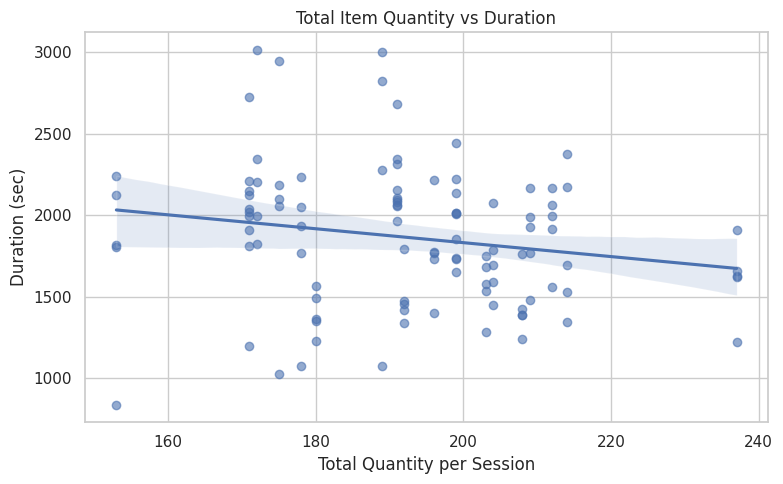

In [14]:
plt.figure(figsize=(8,5))
sns.regplot(data=df_final, x="total_quantity", y="duration_sec",
            scatter_kws={"alpha":0.6})
plt.title("Total Item Quantity vs Duration")
plt.xlabel("Total Quantity per Session")
plt.ylabel("Duration (sec)")
plt.tight_layout()
plt.show()


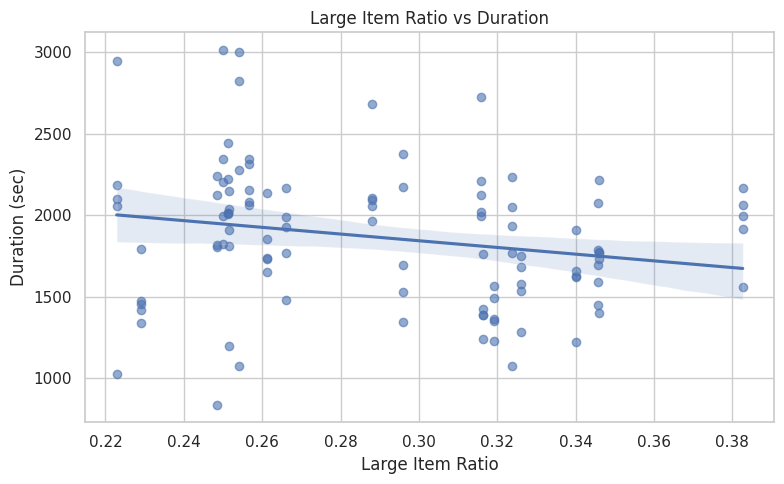

In [15]:
plt.figure(figsize=(8,5))
sns.regplot(data=df_final, x="large_ratio", y="duration_sec",
            scatter_kws={"alpha":0.6})
plt.title("Large Item Ratio vs Duration")
plt.xlabel("Large Item Ratio")
plt.ylabel("Duration (sec)")
plt.tight_layout()
plt.show()


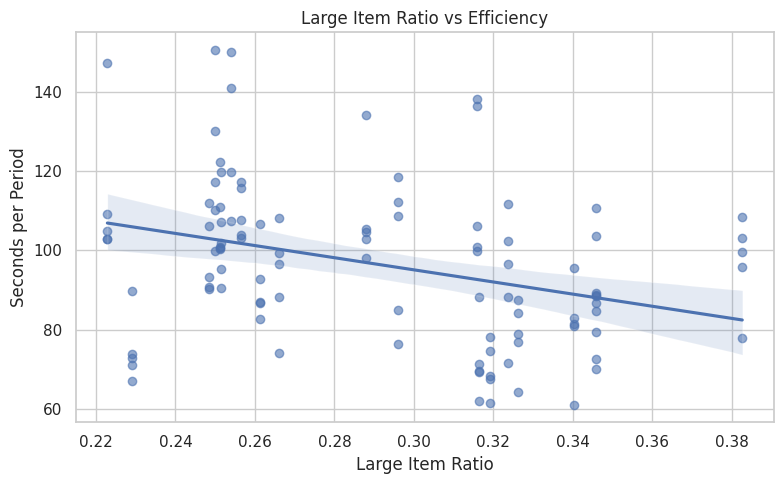

In [16]:
plt.figure(figsize=(8,5))
sns.regplot(data=df_final, x="large_ratio", y="sec_per_period",
            scatter_kws={"alpha":0.6})
plt.title("Large Item Ratio vs Efficiency")
plt.xlabel("Large Item Ratio")
plt.ylabel("Seconds per Period")
plt.tight_layout()
plt.show()


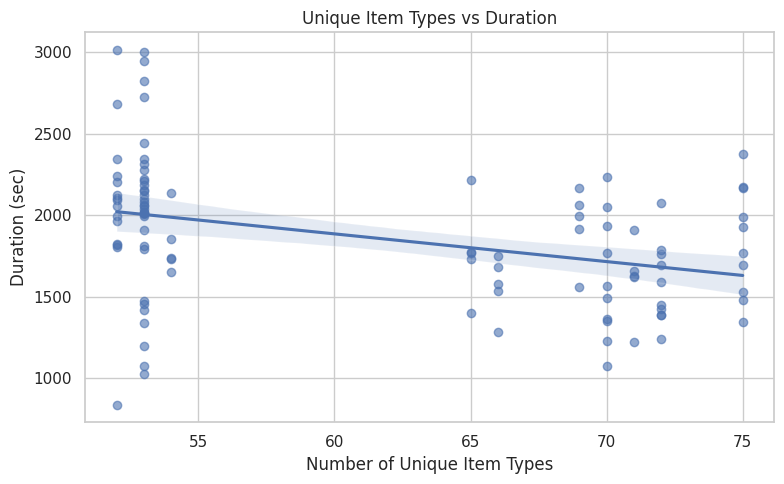

In [17]:
plt.figure(figsize=(8,5))
sns.regplot(data=df_final, x="unique_item_types", y="duration_sec",
            scatter_kws={"alpha":0.6})
plt.title("Unique Item Types vs Duration")
plt.xlabel("Number of Unique Item Types")
plt.ylabel("Duration (sec)")
plt.tight_layout()
plt.show()


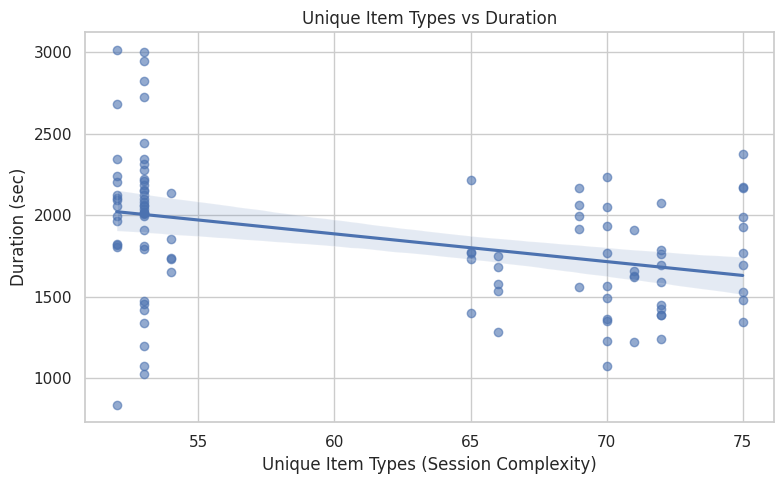

In [20]:
plt.figure(figsize=(8,5))
sns.regplot(data=df_final, x="unique_item_types", y="duration_sec",
            scatter_kws={"alpha":0.6})
plt.title("Unique Item Types vs Duration")
plt.xlabel("Unique Item Types (Session Complexity)")
plt.ylabel("Duration (sec)")
plt.tight_layout()
plt.show()


In [22]:
gender_map = {
    "U0101": "F",
    "U0102": "F",
    "U0103": "F",
    "U0104": "F",
    "U0105": "F",
    "U0106": "F",
    "U0107": "F",
    "U0108": "F",
    "U0109": "M",
    "U0110": "F",
    "U0111": "F",

    "U0201": "M",
    "U0202": "F",
    "U0203": "F",
    "U0204": "F",
    "U0205": "F",
    "U0206": "M",
    "U0207": "F",
    "U0208": "M",
    "U0209": "M",
    "U0210": "F",
}



In [23]:
df_final["gender"] = df_final["Subject"].map(gender_map)


In [24]:
df_final[["Subject", "gender"]].head(20)


,Subject,gender
0,U0101,F
1,U0101,F
2,U0101,F
3,U0101,F
4,U0101,F
5,U0102,F
6,U0102,F
7,U0102,F
8,U0102,F
9,U0102,F


In [25]:
experience_map = {
    "None": 0,
    "-": 0,
    "1 Month": 1,
    "3 Month": 3,
    "6 Month": 6,
    "10 Month": 10,
    "1 Month": 1,
    "1 Year": 12,
    "2 Years": 24,
    "3 Years": 36,
    "4 Year": 48,
    "4 Years": 48,
    "20 Month": 20,
}


In [38]:
experience_map = {
    "U0101": 0,
    "U0102": 0,
    "U0103": 6,
    "U0104": 1,
    "U0105": 48,
    "U0106": 1,
    "U0107": 36,
    "U0108": 36,
    "U0109": 6,
    "U0110": 10,
    "U0111": 24,

    "U0201": 0,
    "U0202": 48,  # same as U0105
    "U0203": 36,  # same as U0108
    "U0204": 12,  # same as U0110
    "U0205": 36,  # same as U0107
    "U0206": 0,
    "U0207": 20,
    "U0208": 0,
    "U0209": 0,
    "U0210": 6,   # same as U0103
}


In [39]:
df_final["experience_raw"] = df_final["Subject"].map(experience_map)


In [40]:
df_final[["Subject", "experience_raw"]].head(20)


,Subject,experience_raw
0,U0101,0
1,U0101,0
2,U0101,0
3,U0101,0
4,U0101,0
5,U0102,0
6,U0102,0
7,U0102,0
8,U0102,0
9,U0102,0


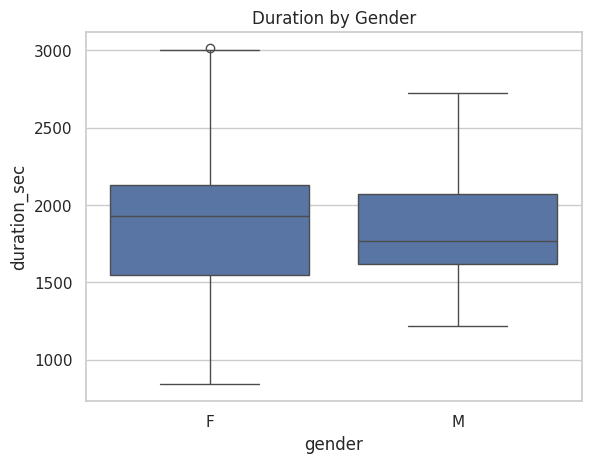

In [28]:
sns.boxplot(data=df_final, x="gender", y="duration_sec")
plt.title("Duration by Gender")
plt.show()


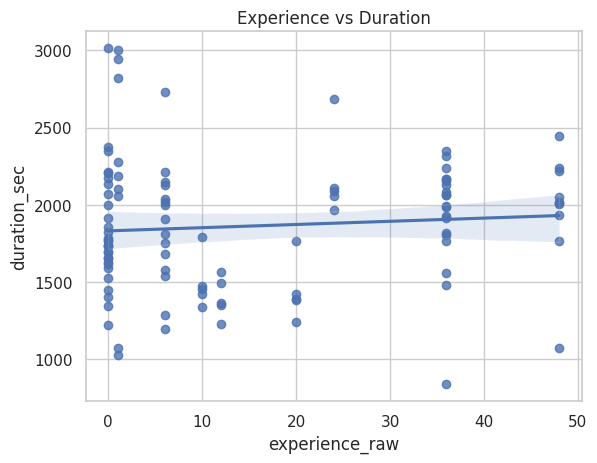

In [41]:
sns.regplot(data=df_final, x="experience_raw", y="duration_sec")
plt.title("Experience vs Duration")
plt.show()


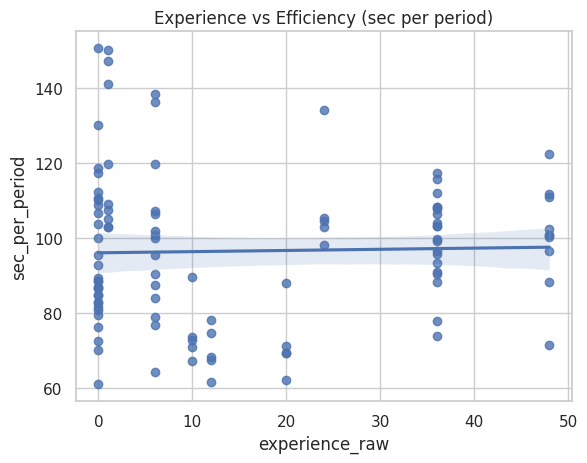

In [42]:
sns.regplot(data=df_final, x="experience_raw", y="sec_per_period")
plt.title("Experience vs Efficiency (sec per period)")
plt.show()


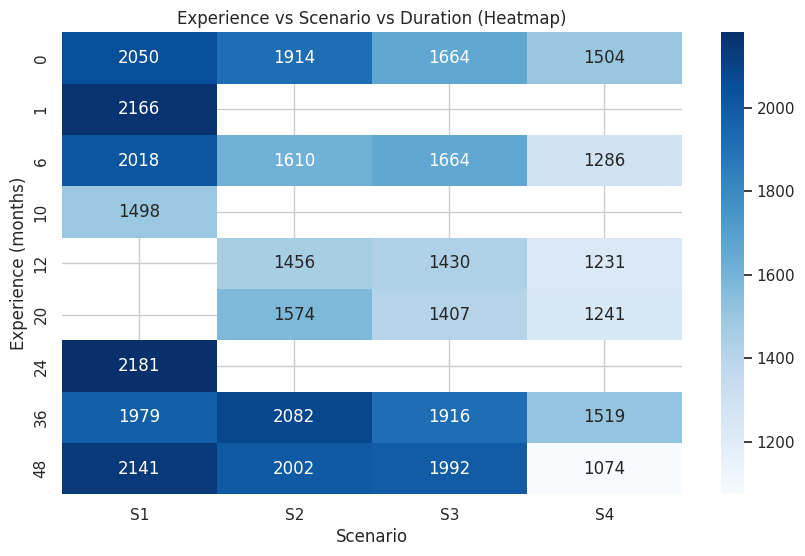

In [43]:
pivot = df_final.pivot_table(
    index="experience_raw",
    columns="Scenario",
    values="duration_sec",
    aggfunc="mean"
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues")
plt.title("Experience vs Scenario vs Duration (Heatmap)")
plt.xlabel("Scenario")
plt.ylabel("Experience (months)")
plt.show()


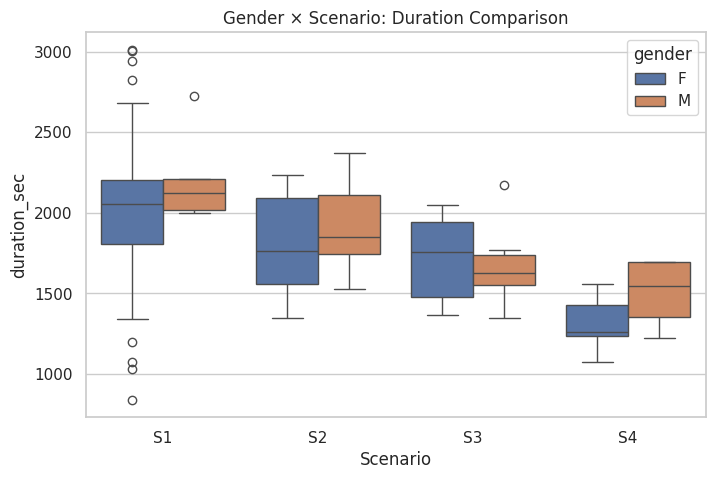

In [44]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_final, x="Scenario", y="duration_sec", hue="gender")
plt.title("Gender × Scenario: Duration Comparison")
plt.show()


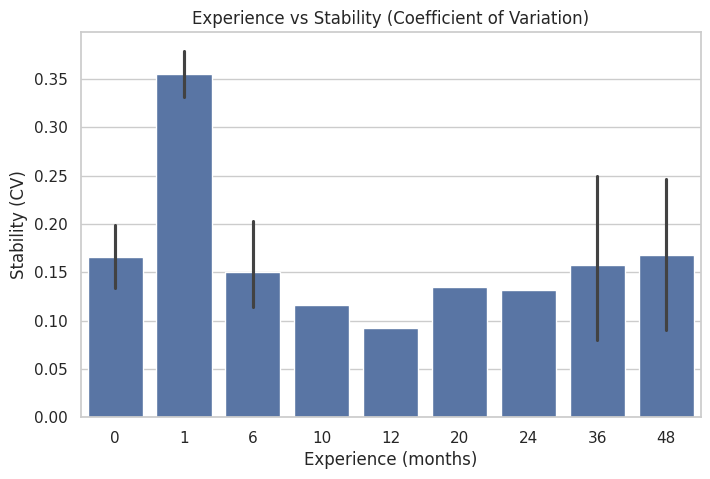

In [45]:
worker_stats = (
    df_final.groupby("Subject")["duration_sec"]
            .agg(["mean", "std"])
            .reset_index()
)

worker_stats["cv"] = worker_stats["std"] / worker_stats["mean"]
worker_stats["experience"] = worker_stats["Subject"].map(experience_map)

plt.figure(figsize=(8,5))
sns.barplot(data=worker_stats, x="experience", y="cv")
plt.title("Experience vs Stability (Coefficient of Variation)")
plt.xlabel("Experience (months)")
plt.ylabel("Stability (CV)")
plt.show()


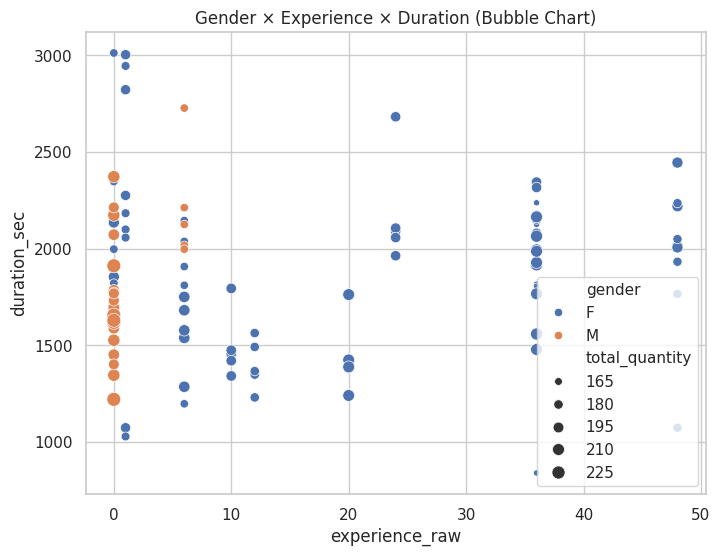

In [46]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_final,
    x="experience_raw",
    y="duration_sec",
    hue="gender",
    size="total_quantity",
    sizes=(20,100)
)
plt.title("Gender × Experience × Duration (Bubble Chart)")
plt.show()


=== Operation 평균 시간 ===
                operation  action_duration
0            Assemble Box         3.032671
1        Attach Box Label         3.069150
2   Attach Shipping Label         3.145750
3               Close Box         4.261977
4          Fill out Order         1.928333
5            Insert Items         4.003897
6                    Null         2.641333
7                 Picking         2.616328
8       Put on Back Table         1.501778
9     Relocate Item Label         3.415491
10             Scan Label         1.638317

=== Action 평균 시간 (상위 20개) ===
                   action  action_duration
0      Put Item Small Bag         7.035750
1             Attach Tape         6.087053
2   Attach Shipping Label         5.323450
3    Insert Item into Box         4.294682
4              Write Sign         4.171850
5               Scan Item         3.876950
6        Write Check Mark         3.581650
7           Pick Up Sheet         3.378000
8   Pick Up Assembled Box         3.248000

/tmp/ipython-input-3846087245.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=act_mean, x="action_duration", y="action", palette="Blues_r")


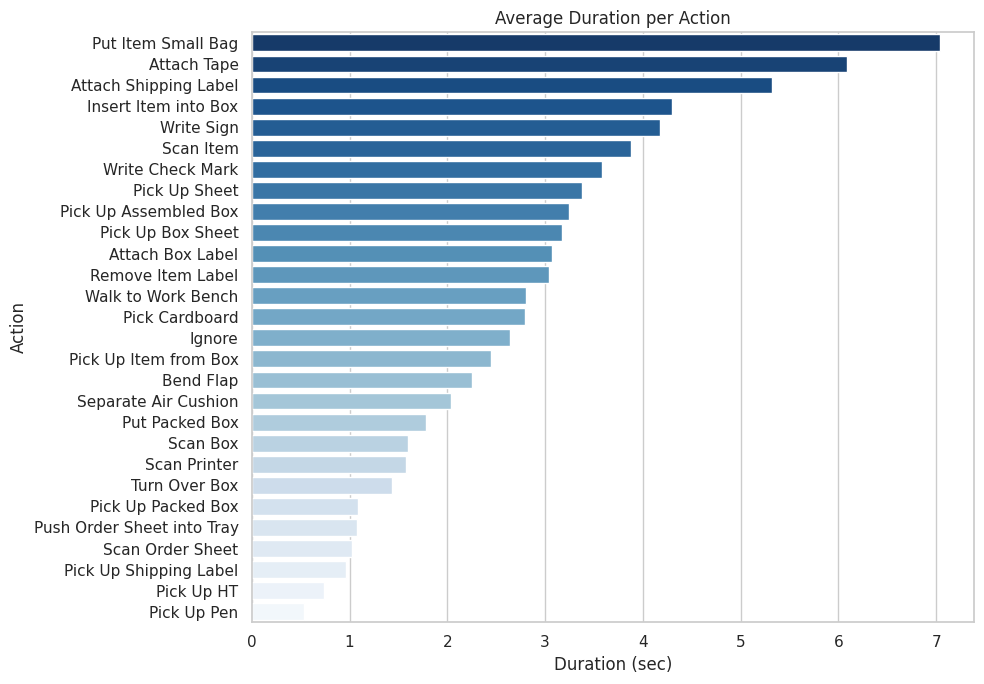

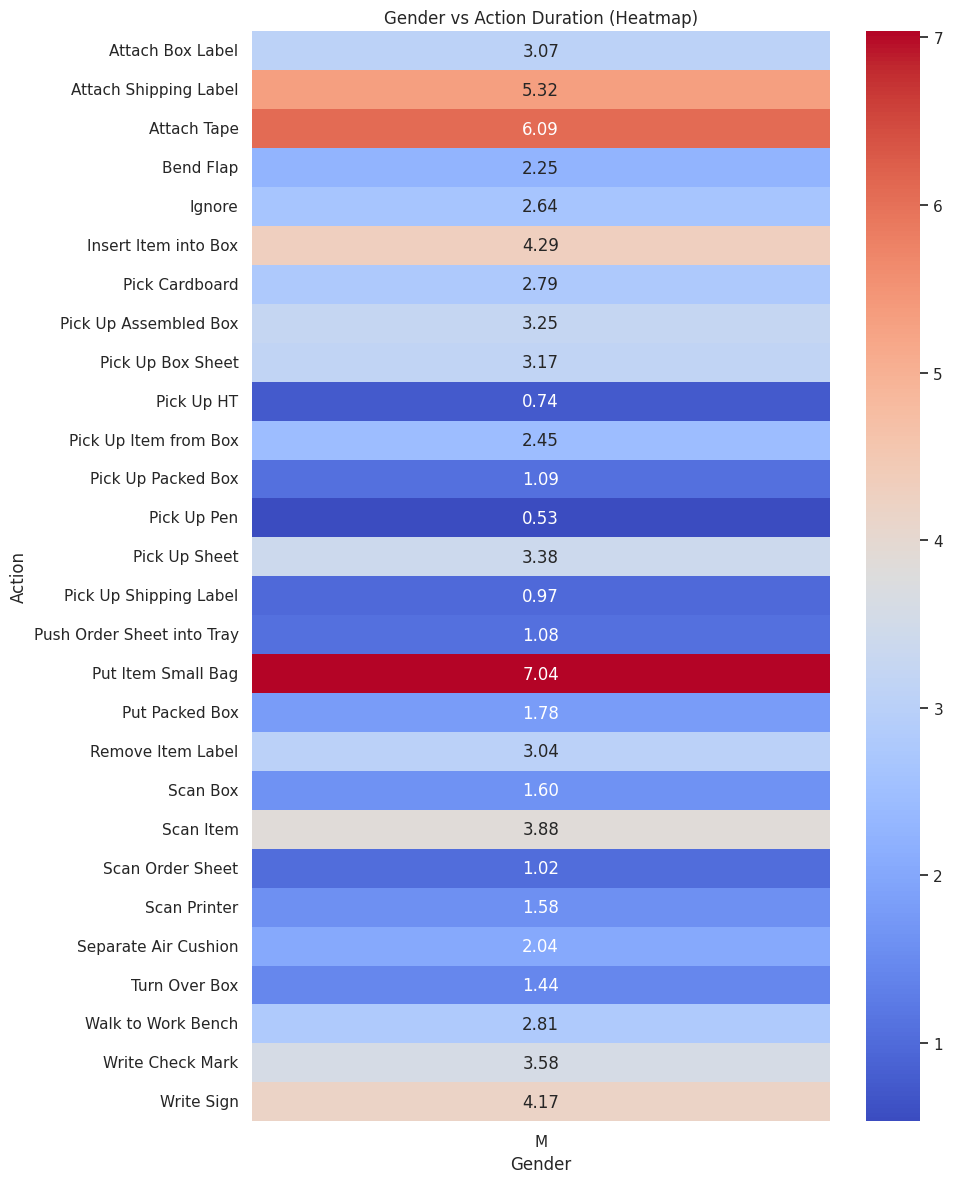

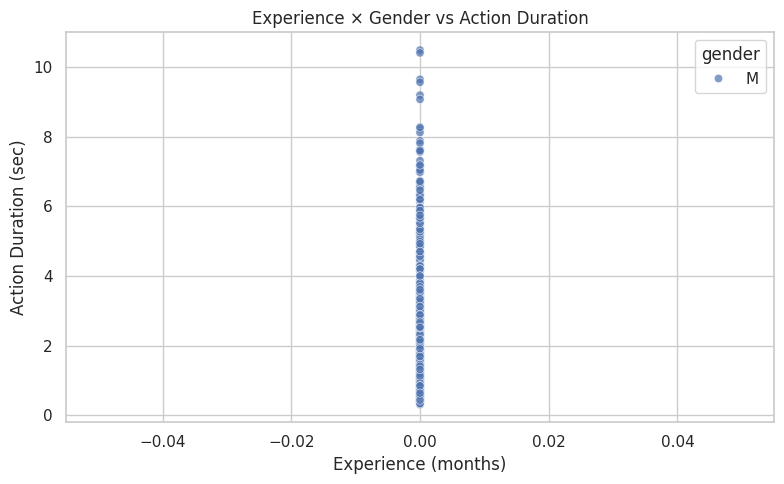



★★★ 분석 완료! Action-level 분석 데이터와 그래프가 생성되었습니다. ★★★


In [48]:
# ============================================
# 0. 라이브러리
# ============================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


# ============================================
# 1. 파일 로드
# ============================================
df_act = pd.read_csv("/content/openpack-dataset/S0500.csv")


# 시간 정렬 및 datetime 변환
df_act["start"] = pd.to_datetime(df_act["start"])
df_act = df_act.sort_values("start").reset_index(drop=True)


# ============================================
# 2. Action Duration 계산
# ============================================
df_act["next_start"] = df_act["start"].shift(-1)
df_act["action_duration"] = (
    df_act["next_start"] - df_act["start"]
).dt.total_seconds()

df_act = df_act.dropna(subset=["action_duration"])


# ============================================
# 3. Gender / Experience 매핑
# ============================================
gender_map = {
    "U0101": "F","U0102": "F","U0103": "F","U0104": "F","U0105": "F",
    "U0106": "F","U0107": "F","U0108": "F","U0109": "M","U0110": "F",
    "U0111": "F","U0201": "M","U0202": "F","U0203": "F","U0204": "F",
    "U0205": "F","U0206": "M","U0207": "F","U0208": "M","U0209": "M",
    "U0210": "F"
}

experience_map = {
    "U0101":0,"U0102":0,"U0103":6,"U0104":1,"U0105":48,
    "U0106":1,"U0107":36,"U0108":36,"U0109":6,"U0110":10,
    "U0111":24,"U0201":0,"U0202":48,"U0203":36,"U0204":12,
    "U0205":36,"U0206":0,"U0207":20,"U0208":0,"U0209":0,
    "U0210":6
}

df_act["gender"] = df_act["user"].map(gender_map)
df_act["experience"] = df_act["user"].map(experience_map)


# ============================================
# 4. Operation / Action 별 평균 시간
# ============================================
op_mean = df_act.groupby("operation")["action_duration"].mean().reset_index()
act_mean = (
    df_act.groupby("action")["action_duration"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

print("=== Operation 평균 시간 ===")
print(op_mean)

print("\n=== Action 평균 시간 (상위 20개) ===")
print(act_mean.head(20))


# ============================================
# 5. Gender × Action 속도 차이
# ============================================
gender_action = (
    df_act.groupby(["gender", "action"])["action_duration"]
    .mean()
    .reset_index()
)

# Pivot for heatmap
pivot_gender_action = gender_action.pivot(
    index="action", columns="gender", values="action_duration"
)


# ============================================
# 6. Experience × Action 속도 차이
# ============================================
exp_action = (
    df_act.groupby(["experience", "action"])["action_duration"]
    .mean()
    .reset_index()
)


# ============================================
# 7. 시각화
# ============================================

# (A) Action별 평균 duration barplot
plt.figure(figsize=(10,7))
sns.barplot(data=act_mean, x="action_duration", y="action", palette="Blues_r")
plt.title("Average Duration per Action")
plt.xlabel("Duration (sec)")
plt.ylabel("Action")
plt.tight_layout()
plt.show()


# (B) Gender × Action duration heatmap
plt.figure(figsize=(10,12))
sns.heatmap(pivot_gender_action, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Gender vs Action Duration (Heatmap)")
plt.xlabel("Gender")
plt.ylabel("Action")
plt.tight_layout()
plt.show()


# (C) Experience × Duration scatterplot
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_act,
    x="experience",
    y="action_duration",
    hue="gender",
    alpha=0.7
)
plt.title("Experience × Gender vs Action Duration")
plt.xlabel("Experience (months)")
plt.ylabel("Action Duration (sec)")
plt.tight_layout()
plt.show()


print("\n\n★★★ 분석 완료! Action-level 분석 데이터와 그래프가 생성되었습니다. ★★★")
